In [3]:
import zipfile

# specify the zip file name
zip_file = './data/dataset.zip'
# specify the directory to extract to
extract_to = './data'

# open the zip file in read mode
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # extract all the contents
    zip_ref.extractall(extract_to)

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import unidecode
import nltk
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Đọc bộ dữ liệu

In [5]:
dataset_path = './data/dataset/all-data.csv'
# định nghĩa tên cột
names = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names=names, header=None, encoding='ISO-8859-1')
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [6]:
classes = {
    class_name: index for index, class_name in enumerate(df['sentiment'].unique())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


### Preprocessing

In [7]:
english_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

def text_normalize(text):
    text = unidecode.unidecode(text)
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in english_stopwords])
    return text

In [8]:
df['content'] = df['content'].apply(text_normalize)

### Build vocabulary

In [9]:
vocab = []

for content in df['content']:
    contents = content.split()
    for word in contents:
        if word not in vocab:
            vocab.append(word)

vocab.append('UNK')
vocab.append('PAD')

word2idx = {word: idx for idx, word in enumerate(vocab)}
print(f'Vocab size: {len(vocab)}')

Vocab size: 8903


### Tokenizer

In [10]:
def transform_text(text, vocab, max_seq):
    tokens = []
    for word in text.split():
        try:
            tokens.append(vocab[word])
        except:
            tokens.append(vocab['UNK'])

    if len(tokens) < max_seq:
        tokens += [vocab['PAD']] * (max_seq - len(tokens))
    else:
        tokens = tokens[:max_seq]

    return tokens

### Chia bộ dữ liệu train-test

In [11]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()


x_train, x_val, y_train, y_val = train_test_split(
    texts, labels, test_size=val_size, random_state=seed, shuffle=is_shuffle)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=test_size, random_state=seed, shuffle=is_shuffle)

### Build dataLoader

In [24]:
class FinancialNews(Dataset):
    def __init__(self, x, y, transform_text, vocab, max_seq):
        self.x = x
        self.y = y
        self.transform_text = transform_text
        self.vocab = vocab
        self.max_seq = max_seq

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        text = self.x[idx]
        label = self.y[idx]

        if self.transform_text != None:
            text = self.transform_text(text, self.vocab, self.max_seq)

        text = torch.tensor(text)
        return text, label

In [25]:
max_seq_len = 32

train_dataset = FinancialNews(x_train, y_train, transform_text, word2idx, max_seq_len)
val_dataset = FinancialNews(
    x_val, y_val, transform_text, word2idx, max_seq_len)
test_dataset = FinancialNews(
    x_test, y_test, transform_text, word2idx, max_seq_len)


train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)

val_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

In [27]:
train_iter = iter(train_loader)
train_batch = next(train_iter)

# Kiểm tra nội dung của batch
inputs, labels = train_batch  # Giả sử dataset trả về (inputs, labels)
print("Inputs shape:", inputs.shape)
print("Labels shape:", labels.shape)

Inputs shape: torch.Size([128, 32])
Labels shape: torch.Size([128])


### Build model

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, n_classes, dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers,
                          batch_first=True)
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, 16)
        self.classifier = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, h_rnn = self.rnn(x)
        out = self.norm(h_rnn[-1,:,:])
        out = self.dropout(out)
        out = self.fc(out)
        out = self.classifier(out)
        return out

#### Test model

In [15]:
vocab_size = 5000  
token_dim = 300 
hidden_dim = 128 
n_layers = 2  
n_classes = 3  
dropout_prob = 0.5  

mode_test = SentimentClassifier(vocab_size, token_dim,
                            hidden_dim, n_layers, n_classes, dropout_prob)

batch_size = 4
seq_len = 10
x = torch.randint(0, vocab_size, (batch_size, seq_len)) 
y = torch.randint(0, n_classes, (batch_size,)) 

mode_test.eval()
out = mode_test(x) 


### Khởi tạo model

In [28]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
vocab_size = len(vocab)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

### Cài đặt hàm loss và optimizer

In [30]:
lr = 1e-4
epochs = 50
critertion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Thực hiện huấn luyện

In [36]:
def compute_accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y_true).sum().item()
    return correct / len(y_true)

def fit(
    model, train_loader, val_loader, criterion , optimizer, epochs, device
):
    train_losses = []
    val_losses = []
    acces_train = []
    acces_val = []

    for epoch in range(epochs):
        batch_train_losses = []
        acc_train = []
        acc_val = []

        model.train()
        for idx, (texts, labels) in enumerate(train_loader):
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            acc_train.append(compute_accuracy(outputs, labels))

        val_loss, acc_val = evaluate(model, val_loader, criterion, device)


        train_losses.append(np.mean(batch_train_losses))
        val_losses.append(val_loss)
        acces_train.append(np.mean(acc_train))
        acces_val.append(acc_val)

        print(
            f"EPOCH {epoch + 1}: \tTrain loss: {np.mean(batch_train_losses):.4f} \tVal loss: {val_loss:.4f}"
        )


    return train_losses, val_losses, acces_train, acces_val


def evaluate(model, data_loader, criterion, device):
    model.eval()
    losses = []
    acc = []

    with torch.no_grad():
        for idx, (texts, labels) in enumerate(data_loader):
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            acc.append(compute_accuracy(outputs, labels))

    losses = np.mean(losses)
    acc = np.mean(acc)

    return losses, acc

### Đánh giá mô hình

In [37]:
train_losses, val_losses, acces_train, acces_val = fit(
    model,
    train_loader,
    val_loader,
    critertion,
    optimizer,
    epochs,
    device,
)

EPOCH 1: 	Train loss: 0.8349 	Val loss: 0.8670
EPOCH 2: 	Train loss: 0.8183 	Val loss: 0.8751
EPOCH 3: 	Train loss: 0.8176 	Val loss: 0.8862
EPOCH 4: 	Train loss: 0.8128 	Val loss: 0.8694
EPOCH 5: 	Train loss: 0.7973 	Val loss: 0.8670
EPOCH 6: 	Train loss: 0.7948 	Val loss: 0.8670
EPOCH 7: 	Train loss: 0.7869 	Val loss: 0.8759
EPOCH 8: 	Train loss: 0.7863 	Val loss: 0.8576
EPOCH 9: 	Train loss: 0.7801 	Val loss: 0.8664
EPOCH 10: 	Train loss: 0.7739 	Val loss: 0.8658
EPOCH 11: 	Train loss: 0.7663 	Val loss: 0.8989
EPOCH 12: 	Train loss: 0.7627 	Val loss: 0.8621
EPOCH 13: 	Train loss: 0.7544 	Val loss: 0.8761
EPOCH 14: 	Train loss: 0.7532 	Val loss: 0.8689
EPOCH 15: 	Train loss: 0.7429 	Val loss: 0.8630
EPOCH 16: 	Train loss: 0.7333 	Val loss: 0.8502
EPOCH 17: 	Train loss: 0.7370 	Val loss: 0.8881
EPOCH 18: 	Train loss: 0.7299 	Val loss: 0.9267
EPOCH 19: 	Train loss: 0.7307 	Val loss: 0.8681
EPOCH 20: 	Train loss: 0.7185 	Val loss: 0.8753
EPOCH 21: 	Train loss: 0.7108 	Val loss: 0.8684
E

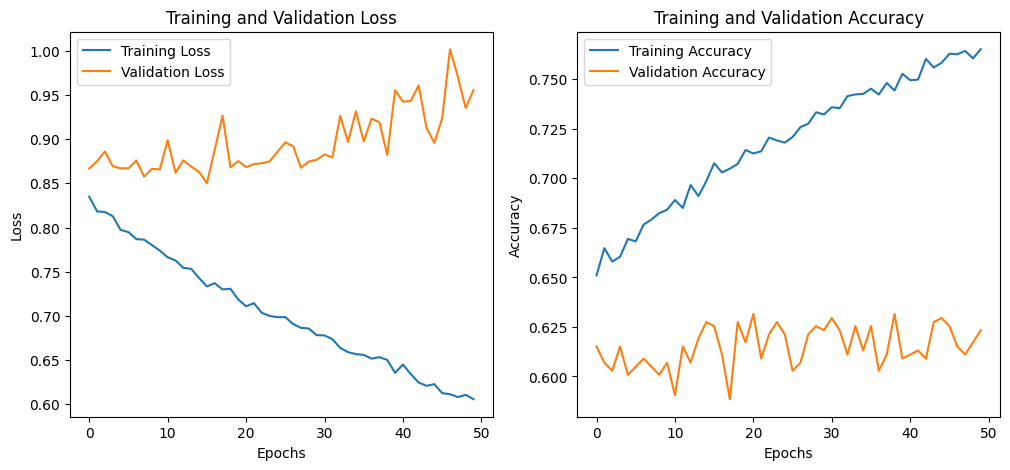

In [38]:
plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(acces_train, label='Training Accuracy')
plt.plot(acces_val, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()